# Dutch News & Politicians Network Analysis
This notebook contains all the code for the results in my essay for "AI for Society". For information on the dataset see the README. 

In [114]:
import collections
import io
import json
import os
import requests
import time


import pandas as pd
import numpy as np
import networkx as nx

## Dataset

In [93]:
csv_string = """
Account,Occupation
MinPres,P
hugodejonge,P
KajsaOllongren,P
carolaschouten,P
RaymondKnops,P
bvantwout,P
SigridKaag,P
ministerBlok,P
MinBijleveld,P
CvNieuwenhuizen,P
WBHoekstra,P
ferdgrapperhaus,P
ivanengelshoven,P
wkoolmees,P
SanderDekker,P
tamaravanark,P
arieslob,P
thierrybaudet,C
MarijnissenL,C
F_azarkan,C
CvanBrenk,C
jesseklaver,C
PloumenLilianne,C
keesvdstaaij,C
geertwilderspvv,C
gertjansegers,C
PieterHeerma,C
estherouwehand,C
dijkhoff,C
RobJetten,C
NOS,N
RTLnieuws,N
mauricedehond,J
telegraaf,N
fritswester,J
XandervdWulp,J
noorlanderarjan,J
decorrespondent,N
parool,N
volkskrant,N
nrc,N
rcbregman,J
EOnl,N
JoostVullings,J
SaskiaBelleman,J
"""

## Create dataframe

In [94]:
csv = io.StringIO(csv_string)
twitter_df = pd.read_csv(csv)
twitter_df

,Account,Occupation
0,MinPres,P
1,hugodejonge,P
2,KajsaOllongren,P
3,carolaschouten,P
4,RaymondKnops,P
5,bvantwout,P
6,SigridKaag,P
7,ministerBlok,P
8,MinBijleveld,P
9,CvNieuwenhuizen,P


## Set up API environment

In [96]:
bearer_token = os.environ["BEARER_TOKEN"]

headers = {"Authorization": f"Bearer {bearer_token}"}
ids_url = "https://api.twitter.com/2/users/by?"

def filter_tokens(string):
    string = string.replace("[", "")
    string = string.replace("]", "")
    string = string.replace("'", "")
    string = string.replace(" ", "")

    return string

# get all ids and names and and add them to dataframe
response = requests.get(filter_tokens(f"{ids_url}usernames={list(twitter_df['Account'])}"), headers=headers)
response_dict = response.json()

ids = []
names = []
for user in response_dict['data']:
    ids.append(user['id'])
    names.append(user['name'])
    
twitter_df['ID'] = ids
twitter_df['Name'] = names
twitter_df

,Account,Occupation,ID,Name
0,MinPres,P,155507136,Mark Rutte
1,hugodejonge,P,29785926,Hugo de Jonge
2,KajsaOllongren,P,2561159192,Kajsa Ollongren
3,carolaschouten,P,34575169,Carola Schouten
4,RaymondKnops,P,106144762,Raymond Knops
5,bvantwout,P,24904831,Bas van 't Wout
6,SigridKaag,P,933973531968397312,Sigrid Kaag
7,ministerBlok,P,930373420788961281,Stef Blok
8,MinBijleveld,P,922457956574253056,Ank Bijleveld
9,CvNieuwenhuizen,P,91981058,Cora van Nieuwenhuizen


In [97]:
def following_url(id):
    return f"https://api.twitter.com/2/users/{id}/following"

following_dict = dict()
target_set = set(twitter_df['Account'])

# for each user get all following
for username, user_id in zip(twitter_df['Account'], ids):
    response = requests.get(following_url(user_id), headers=headers, params={'max_results': 1000})
    time.sleep(60)
    response_dict = response.json()
    following_set = {user['username'] for user in response_dict['data']}
    
    # if more following available, request them and add them to following_set
    next_token = response_dict['meta'].get('next_token', 3.14)
    while next_token != 3.14:
        response = requests.get(following_url(user_id), headers=headers, params={'max_results': 1000, 'pagination_token': next_token})
        time.sleep(60)
        response_dict = response.json()
        following_set = following_set | {user['username'] for user in response_dict['data']}
        
        next_token = response_dict['meta'].get('next_token', 3.14)
        
    # filter on designated users 
    following_dict[username] = following_set & target_set

print(following_dict)

{'MinPres': {'SanderDekker', 'carolaschouten', 'CvNieuwenhuizen', 'ministerBlok', 'WBHoekstra', 'KajsaOllongren', 'MinBijleveld', 'ivanengelshoven', 'bvantwout', 'arieslob', 'SigridKaag', 'wkoolmees', 'hugodejonge', 'tamaravanark', 'RaymondKnops', 'ferdgrapperhaus'}, 'hugodejonge': {'WBHoekstra', 'XandervdWulp', 'tamaravanark', 'mauricedehond', 'RTLnieuws', 'RobJetten', 'dijkhoff', 'MinPres', 'volkskrant', 'fritswester', 'keesvdstaaij', 'KajsaOllongren', 'NOS', 'gertjansegers', 'jesseklaver', 'RaymondKnops', 'MarijnissenL', 'SanderDekker', 'JoostVullings', 'carolaschouten', 'CvNieuwenhuizen', 'nrc', 'MinBijleveld', 'ivanengelshoven', 'PieterHeerma', 'telegraaf', 'ministerBlok', 'noorlanderarjan', 'bvantwout', 'SigridKaag', 'wkoolmees', 'arieslob', 'ferdgrapperhaus', 'estherouwehand'}, 'KajsaOllongren': {'WBHoekstra', 'parool', 'XandervdWulp', 'RobJetten', 'MinPres', 'volkskrant', 'fritswester', 'decorrespondent', 'NOS', 'gertjansegers', 'hugodejonge', 'jesseklaver', 'RaymondKnops', 'Sa

## Create the edgelist

In [98]:
edges_df = pd.DataFrame(columns=['From', 'To'])

idx = 0 
for user in following_dict.keys():
    if following_dict[user] != set():
        for following in following_dict[user]:
            edges_df = edges_df.append(pd.DataFrame(data={'From': user, 'To': following}, index=[idx]))
            idx += 1

edges_df.to_csv('~/Desktop/UvA/aiforsociety/essay/edges.csv', index=False)

In [99]:
edges_df = pd.read_csv('~/Desktop/UvA/aiforsociety/essay/edges.csv')

edges_df

,From,To
0,MinPres,SanderDekker
1,MinPres,carolaschouten
2,MinPres,CvNieuwenhuizen
3,MinPres,ministerBlok
4,MinPres,WBHoekstra
...,...,...
858,SaskiaBelleman,fritswester
859,SaskiaBelleman,telegraaf
860,SaskiaBelleman,geertwilderspvv
861,SaskiaBelleman,RTLnieuws


# Network Analysis

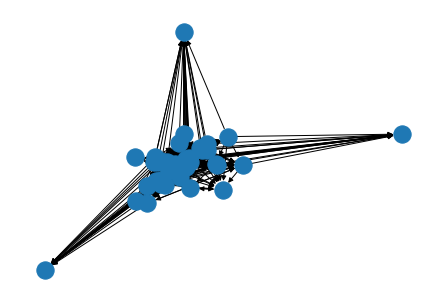

In [111]:
G = nx.convert_matrix.from_pandas_edgelist(edges_df,source='From', target='To', create_using=nx.DiGraph())
nx.draw(G)

## Pagerank

In [122]:
def sort_dict(dictionary):
    return {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}

pagerank_dict = nx.algorithms.link_analysis.pagerank_alg.pagerank(G)
sort_dict(pagerank_dict)

{'rcbregman': 0.033978264260694176,
 'fritswester': 0.03313702533751056,
 'XandervdWulp': 0.032117348295421955,
 'jesseklaver': 0.031484522041066165,
 'MinPres': 0.03080936119152128,
 'SigridKaag': 0.03008103435143468,
 'hugodejonge': 0.029177031101055184,
 'keesvdstaaij': 0.028858915733411386,
 'arieslob': 0.028054947550227128,
 'WBHoekstra': 0.027913445791414297,
 'SanderDekker': 0.026857551924958253,
 'geertwilderspvv': 0.02675493913803591,
 'ferdgrapperhaus': 0.026663932428120984,
 'tamaravanark': 0.0264922054650067,
 'wkoolmees': 0.026293920231521963,
 'decorrespondent': 0.026254143117029543,
 'mauricedehond': 0.025256127766733652,
 'KajsaOllongren': 0.024601102591708224,
 'CvNieuwenhuizen': 0.024188982504934002,
 'carolaschouten': 0.024103823793320076,
 'ministerBlok': 0.02342048038792569,
 'RaymondKnops': 0.023411526136664428,
 'JoostVullings': 0.022999124392271378,
 'dijkhoff': 0.022958349494116865,
 'RobJetten': 0.02282246579988778,
 'gertjansegers': 0.02206617288670837,
 'iva

## General network metrics

In [102]:
# diameter = nx.algorithms.distance_measures.diameter(G)
density = nx.classes.function.density(G)
reciprocity = nx.algorithms.reciprocity(G)
print(f"Density of the network: {density}")
print(f"Reciprocity of the network: {reciprocity}")

Density of the network: 0.43585858585858583
Reciprocity of the network: 0.5979142526071842


## In-Degree for News sites

In [103]:
in_degree_dict = dict(G.in_degree)
N_in_degree = {k: v for k, v in in_degree_dict.items() if k in set(twitter_df.loc[twitter_df['Occupation'] == 'N', 'Account'])}
sort_dict(N_in_degree)

{'NOS': 21,
 'telegraaf': 19,
 'RTLnieuws': 18,
 'volkskrant': 18,
 'nrc': 17,
 'decorrespondent': 12,
 'parool': 8,
 'EOnl': 1}

## In-Degree for Politicians and Journalists

In [126]:
PCJ_in_degree = {k: v for k, v in in_degree_dict.items() if k in set(twitter_df.loc[twitter_df['Occupation'] != 'N', 'Account'])}
sort_dict(PCJ_in_degree)

{'MinPres': 30,
 'hugodejonge': 29,
 'fritswester': 29,
 'XandervdWulp': 28,
 'WBHoekstra': 26,
 'arieslob': 26,
 'SanderDekker': 25,
 'wkoolmees': 25,
 'keesvdstaaij': 25,
 'jesseklaver': 25,
 'KajsaOllongren': 24,
 'ferdgrapperhaus': 24,
 'gertjansegers': 24,
 'tamaravanark': 23,
 'mauricedehond': 23,
 'RobJetten': 23,
 'dijkhoff': 23,
 'carolaschouten': 22,
 'CvNieuwenhuizen': 22,
 'ministerBlok': 22,
 'RaymondKnops': 22,
 'JoostVullings': 22,
 'geertwilderspvv': 22,
 'SigridKaag': 20,
 'ivanengelshoven': 19,
 'PieterHeerma': 19,
 'thierrybaudet': 17,
 'MinBijleveld': 16,
 'MarijnissenL': 16,
 'estherouwehand': 15,
 'noorlanderarjan': 14,
 'bvantwout': 13,
 'SaskiaBelleman': 13,
 'rcbregman': 8,
 'CvanBrenk': 7,
 'F_azarkan': 6,
 'PloumenLilianne': 2}

## In-Degree for chairmen and members of cabinet

In [121]:
PC_in_degree = {k: v for k, v in in_degree_dict.items() if k in set(twitter_df.loc[twitter_df['Occupation'] == 'P', 'Account']) | set(twitter_df.loc[twitter_df['Occupation'] == 'C', 'Account'])}
sort_dict(PC_in_degree)

{'MinPres': 30,
 'hugodejonge': 29,
 'WBHoekstra': 26,
 'arieslob': 26,
 'SanderDekker': 25,
 'wkoolmees': 25,
 'keesvdstaaij': 25,
 'jesseklaver': 25,
 'KajsaOllongren': 24,
 'ferdgrapperhaus': 24,
 'gertjansegers': 24,
 'tamaravanark': 23,
 'RobJetten': 23,
 'dijkhoff': 23,
 'carolaschouten': 22,
 'CvNieuwenhuizen': 22,
 'ministerBlok': 22,
 'RaymondKnops': 22,
 'geertwilderspvv': 22,
 'SigridKaag': 20,
 'ivanengelshoven': 19,
 'PieterHeerma': 19,
 'thierrybaudet': 17,
 'MinBijleveld': 16,
 'MarijnissenL': 16,
 'estherouwehand': 15,
 'bvantwout': 13,
 'CvanBrenk': 7,
 'F_azarkan': 6,
 'PloumenLilianne': 2}

## Out-Degree for all users

In [105]:
out_degree_dict = dict(G.out_degree)
sort_dict(out_degree_dict)

{'keesvdstaaij': 39,
 'fritswester': 36,
 'tamaravanark': 35,
 'PieterHeerma': 35,
 'CvNieuwenhuizen': 34,
 'hugodejonge': 34,
 'bvantwout': 33,
 'RobJetten': 33,
 'MarijnissenL': 33,
 'XandervdWulp': 32,
 'arieslob': 29,
 'ivanengelshoven': 28,
 'JoostVullings': 27,
 'KajsaOllongren': 26,
 'noorlanderarjan': 24,
 'ministerBlok': 22,
 'SigridKaag': 22,
 'F_azarkan': 22,
 'MinBijleveld': 21,
 'RaymondKnops': 21,
 'telegraaf': 21,
 'wkoolmees': 20,
 'gertjansegers': 20,
 'CvanBrenk': 20,
 'volkskrant': 18,
 'estherouwehand': 18,
 'WBHoekstra': 17,
 'ferdgrapperhaus': 17,
 'MinPres': 16,
 'SanderDekker': 16,
 'RTLnieuws': 15,
 'carolaschouten': 14,
 'dijkhoff': 14,
 'jesseklaver': 10,
 'parool': 10,
 'mauricedehond': 7,
 'EOnl': 7,
 'SaskiaBelleman': 6,
 'thierrybaudet': 5,
 'rcbregman': 3,
 'PloumenLilianne': 2,
 'decorrespondent': 1,
 'NOS': 0,
 'nrc': 0,
 'geertwilderspvv': 0}

## Community Analysis
Firstly using the asyn_lpa algorithm, secondly using the greedy algorithm. 

In [106]:
asyn_lpa_communities = nx.algorithms.community.label_propagation.asyn_lpa_communities(G)

for i, community in enumerate(asyn_lpa_communities):
    print(f"Community: {i+1}: {community}")

Community: 1: {'SaskiaBelleman', 'rcbregman', 'WBHoekstra', 'parool', 'XandervdWulp', 'tamaravanark', 'mauricedehond', 'RTLnieuws', 'RobJetten', 'MinPres', 'dijkhoff', 'volkskrant', 'PloumenLilianne', 'fritswester', 'keesvdstaaij', 'decorrespondent', 'KajsaOllongren', 'EOnl', 'gertjansegers', 'F_azarkan', 'hugodejonge', 'jesseklaver', 'RaymondKnops', 'MarijnissenL', 'SanderDekker', 'JoostVullings', 'carolaschouten', 'CvNieuwenhuizen', 'MinBijleveld', 'ivanengelshoven', 'PieterHeerma', 'thierrybaudet', 'telegraaf', 'CvanBrenk', 'ministerBlok', 'noorlanderarjan', 'bvantwout', 'arieslob', 'SigridKaag', 'wkoolmees', 'ferdgrapperhaus', 'estherouwehand'}
Community: 2: {'NOS'}
Community: 3: {'nrc'}
Community: 4: {'geertwilderspvv'}


In [120]:
greedy_communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G.to_undirected())
for i, community in enumerate(greedy_communities):
    occupation_dict = collections.Counter(twitter_df.loc[(twitter_df['Account'].isin(community)), 'Occupation'])
    print(f"Community: {i+1}: {set(community)}")
    print(occupation_dict)
        

Community: 1: {'carolaschouten', 'CvNieuwenhuizen', 'nrc', 'WBHoekstra', 'MinBijleveld', 'parool', 'ivanengelshoven', 'tamaravanark', 'RTLnieuws', 'MinPres', 'keesvdstaaij', 'ministerBlok', 'KajsaOllongren', 'NOS', 'bvantwout', 'SigridKaag', 'wkoolmees', 'hugodejonge', 'RaymondKnops', 'ferdgrapperhaus'}
Counter({'P': 15, 'N': 4, 'C': 1})
Community: 2: {'SanderDekker', 'fritswester', 'SaskiaBelleman', 'telegraaf', 'decorrespondent', 'EOnl', 'geertwilderspvv', 'gertjansegers', 'arieslob', 'F_azarkan', 'PieterHeerma', 'mauricedehond', 'dijkhoff'}
Counter({'C': 5, 'J': 3, 'N': 3, 'P': 2})
Community: 3: {'PloumenLilianne', 'JoostVullings', 'CvanBrenk', 'rcbregman', 'noorlanderarjan', 'XandervdWulp', 'thierrybaudet', 'jesseklaver', 'RobJetten', 'volkskrant', 'estherouwehand', 'MarijnissenL'}
Counter({'C': 7, 'J': 4, 'N': 1})
